The code is published under GPLv3 license. See the LICENSE file for details.
Please cite the following paper if you use the code in your work:

```bibtex
some bibtex
```



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [6]:
kx, ky = 124, 124
rx, ry = 50, 50


In [8]:
# load your data
with open(r'data\small_example\SiGe stressor.dat', 'rb') as f:
    data = np.frombuffer(f.read(), dtype=np.float32, offset=0)
data = data.reshape(ry,rx,ky,kx)
data.shape

(50, 50, 124, 124)

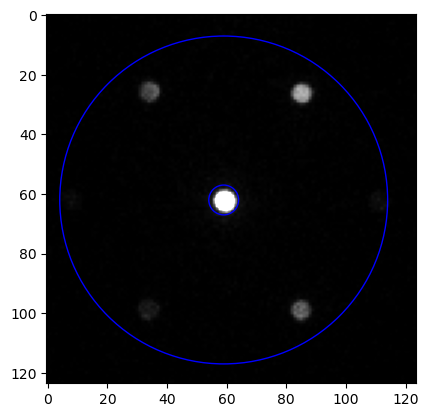

In [10]:
from matplotlib.patches import Circle
intensity_range = 50000
plt.imshow(data[30,30,:,:], vmax=intensity_range, vmin=0)
df4_720 = Circle([59,62], 5, fill=False, color='b')
plt.gca().add_patch(df4_720)
df4_910 = Circle([59,62], 55, fill=False, color='b')
plt.gca().add_patch(df4_910)


In [11]:
example = data[20,28,:,:]/50000

<h1>STEM spectral sampling<h1>

In [5]:
X,Y = np.meshgrid((np.arange(0,ky)-ky/2),(np.arange(0,kx)-kx/2), indexing='xy')

masks = []

# inner and outer radius for your BF virtual detector
inside = (0, 0, 0)
BFoutside = (15,19, 25) 

for inner, outer in zip(inside, BFoutside):
    masks.append((X**2+Y**2<=outer**2)&(X**2+Y**2>=inner**2))
    
# inner and outer radius for your HAADF virtual detector
DFinside = (6,8, 15)#(20,15, )
DFoutside = (47,64, 90)#(100, 100)
# # inside = np.linspace(10, 64, 5)[:-1]
# # outside = np.linspace(10, 64, 5)[1:]
for inner, outer in zip(DFinside, DFoutside):
    masks.append((X**2+Y**2<=outer**2)&(X**2+Y**2>=inner**2)&(X+Y>0)&(X-Y>0))
    masks.append((X**2+Y**2<=outer**2)&(X**2+Y**2>=inner**2)&(X+Y>0)&(X-Y<0))
    masks.append((X**2+Y**2<=outer**2)&(X**2+Y**2>=inner**2)&(X+Y<0)&(X-Y>0))
    masks.append((X**2+Y**2<=outer**2)&(X**2+Y**2>=inner**2)&(X+Y<0)&(X-Y<0))


<h1>random spectral sampling<h1>

In [12]:
from numpy.random import default_rng
# set the number virtual detectors
nspectral = 100
rng = default_rng(seed=43)
masks = [rng.binomial(1.0, 0.1, size=(ky,kx)) for i in range(int(nspectral))]



In [14]:
spectral = []
for mask in masks:
    # fig, (ax1, ax2) = plt.subplots(1, 2)
    img = np.sum(data*mask, axis=(2,3))
    spectral.append(img)
    # ax1.imshow(img)
    # ax2.imshow(mask+example)
spectral = np.array(spectral).reshape(-1,rx*ry).astype(np.float32)
spectral.shape

(100, 2500)

In [15]:
masks = np.array(masks, dtype=np.float32).reshape(-1, kx*ky)
n_spec = masks.shape[0]
masks.shape

(100, 15376)

# spatial sampling  
choose between grid or random sampling

## grid sampling  


In [73]:
X, Y = np.meshgrid(np.arange(1,rx,5), np.arange(1,ry,5), indexing='xy')
spatial = data[Y, X, :, :]
spatial = spatial.reshape(-1, kx*ky).astype(np.float32)
n_spa = spatial.shape[0]
spatial.shape

(49, 16384)

## random sampling

In [16]:
sample_rate = 0.05
np.random.seed(2)
Y, X = np.where(np.random.binomial(1, sample_rate, size=(ry, rx)))
spatial = data[Y, X, :, :]
spatial = spatial.reshape(-1, kx*ky).astype(np.float32)
n_spa = spatial.shape[0]
spatial.shape

(132, 15376)

In [17]:
positions = (Y*rx+X).flatten()

## check spatial sampling

Text(0.5, 1.0, 'sample rate: 5.3%')

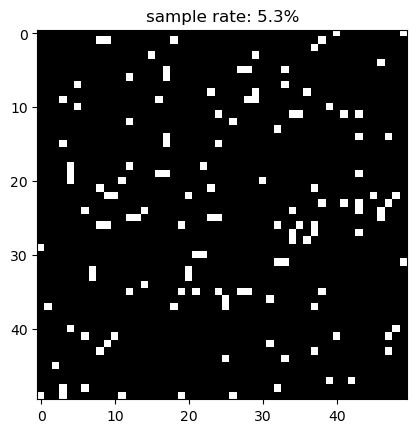

In [18]:
mask_spa = np.zeros((n_spa, rx*ry))
for idx, pos in enumerate(positions):
    mask_spa[idx, pos] = 1
spatial_sample = np.zeros((ry*rx))
spatial_sample[positions] = 1
plt.imshow(spatial_sample.reshape(ry,rx))
plt.title(f'sample rate: {100*n_spa/(rx*ry):.1f}%')

In [19]:
def est_noise(y, noise_type='additive'):
    """
    This function infers the noise in a
    hyperspectral data set, by assuming that the
    reflectance at a given band is well modelled
    by a linear regression on the remaining bands.

    Parameters:
        y: `numpy array`
            a HSI cube ((m*n) x p)

       noise_type: `string [optional 'additive'|'poisson']`

    Returns: `tuple numpy array, numpy array`
        * the noise estimates for every pixel (N x p)
        * the noise correlation matrix estimates (p x p)

    Copyright:
        Jose Nascimento (zen@isel.pt) and Jose Bioucas-Dias (bioucas@lx.it.pt)
        For any comments contact the authors
    """
    def est_additive_noise(r):
        small = 1e-6
        L, N = r.shape
        w=np.zeros((L,N), dtype=np.float32)
        RR=np.dot(r,r.T)
        RRi = np.linalg.pinv(RR+small*np.eye(L))
        RRi = np.matrix(RRi)
        for i in range(L):
            XX = RRi - (RRi[:,i]*RRi[i,:]) / RRi[i,i]
            RRa = RR[:,i]
            RRa[i] = 0
            beta = np.dot(XX, RRa)
            beta[0,i]=0;
            w[i,:] = r[i,:] - np.dot(beta,r)
        Rw = np.diag(np.diag(np.dot(w,w.T) / N))
        return w, Rw

    y = y.T
    L, N = y.shape
    #verb = 'poisson'
    if noise_type == 'poisson':
        sqy = np.sqrt(y * (y > 0))
        u, Ru = est_additive_noise(sqy)
        x = (sqy - u)**2
        w = np.sqrt(x)*u*2
        Rw = np.dot(w,w.T) / N
    # additive
    else:
        w, Rw = est_additive_noise(y)
    return w.T, Rw.T

In [20]:
error, Rn = est_noise(spectral.T, noise_type='poission')

In [21]:
# code retrieve from https://pysptools.sourceforge.io/_modules/pysptools/material_count/vd.html#hysime
def hysime(y, n, Rn):
    """
    Hyperspectral signal subspace estimation

    Parameters:
        y: `numpy array`
            hyperspectral data set (each row is a pixel)
            with ((m*n) x p), where p is the number of bands
            and (m*n) the number of pixels.

        n: `numpy array`
            ((m*n) x p) matrix with the noise in each pixel.

        Rn: `numpy array`
            noise correlation matrix (p x p)

    Returns: `tuple integer, numpy array`
        * kf signal subspace dimension
        * Ek matrix which columns are the eigenvectors that span
          the signal subspace.

    Copyright:
        Jose Nascimento (zen@isel.pt) & Jose Bioucas-Dias (bioucas@lx.it.pt)
        For any comments contact the authors
    """
    y=y.T
    n=n.T
    Rn=Rn.T
    L, N = y.shape
    Ln, Nn = n.shape
    d1, d2 = Rn.shape

    x = y - n;
    Ry = np.dot(y, y.T) / N
    Rx = np.dot(x, x.T) / N
    
    
    E, dx, V = np.linalg.svd(Rx)

    Rn = Rn+np.sum(np.diag(Rx))/L/10**5 * np.eye(L)
    Py = np.diag(np.dot(E.T, np.dot(Ry,E)))
    Pn = np.diag(np.dot(E.T, np.dot(Rn,E)))
    cost_F = -Py + 2 * Pn
    kf = np.sum(cost_F < 0)
    ind_asc = np.argsort(cost_F)
    Ek = E[:, ind_asc[0:kf]]
    return kf, Ek # Ek.T ?

In [22]:
n_members, _ = hysime(spectral.T, error, Rn)
n_members

25

In [23]:
# code retrieve from https://github.com/Laadr/VCA/blob/12dbe40249f8a230917c456ef4668dadebf43bd5/VCA.py#L76
# originally from http://www.lx.it.pt/~bioucas/code.htm
import scipy as sp
import scipy.linalg as splin


#############################################
# Internal functions
#############################################

def estimate_snr(Y,r_m,x):

  [L, N] = Y.shape           # L number of bands (channels), N number of pixels
  [p, N] = x.shape           # p number of endmembers (reduced dimension)
  
  P_y     = sp.sum(Y**2)/float(N)
  P_x     = sp.sum(x**2)/float(N) + sp.sum(r_m**2)
  snr_est = 10*sp.log10( (P_x - p/L*P_y)/(P_y - P_x) )

  return snr_est



def vca(Y,R,verbose = True,snr_input = 0):
# Vertex Component Analysis
#
# Ae, indice, Yp = vca(Y,R,verbose = True,snr_input = 0)
#
# ------- Input variables -------------
#  Y - matrix with dimensions L(channels) x N(pixels)
#      each pixel is a linear mixture of R endmembers
#      signatures Y = M x s, where s = gamma x alfa
#      gamma is a illumination perturbation factor and
#      alfa are the abundance fractions of each endmember.
#  R - positive integer number of endmembers in the scene
#
# ------- Output variables -----------
# Ae     - estimated mixing matrix (endmembers signatures)
# indice - pixels that were chosen to be the most pure
# Yp     - Data matrix Y projected.   
#
# ------- Optional parameters---------
# snr_input - (float) signal to noise ratio (dB)
# v         - [True | False]
# ------------------------------------
#
# Author: Adrien Lagrange (adrien.lagrange@enseeiht.fr)
# This code is a translation of a matlab code provided by 
# Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
# available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
# Translation of last version at 22-February-2018 (Matlab version 2.1 (7-May-2004))
#
# more details on:
# Jose M. P. Nascimento and Jose M. B. Dias 
# "Vertex Component Analysis: A Fast Algorithm to Unmix Hyperspectral Data"
# submited to IEEE Trans. Geosci. Remote Sensing, vol. .., no. .., pp. .-., 2004
# 
# 

  #############################################
  # Initializations
  #############################################
  

  [L, N]=Y.shape   # L number of bands (channels), N number of pixels
       
  R = int(R)
  
        
  #############################################
  # SNR Estimates
  #############################################

  if snr_input==0:
    y_m = sp.mean(Y,axis=1,keepdims=True)
    Y_o = Y - y_m           # data with zero-mean
    Ud  = splin.svd(sp.dot(Y_o,Y_o.T)/float(N))[0][:,:R]  # computes the R-projection matrix 
    x_p = sp.dot(Ud.T, Y_o)                 # project the zero-mean data onto p-subspace

    SNR = estimate_snr(Y,y_m,x_p);
    
    if verbose:
      print("SNR estimated = {}[dB]".format(SNR))
  else:
    SNR = snr_input
    if verbose:
      print("input SNR = {}[dB]\n".format(SNR))

  SNR_th = 15 + 10*sp.log10(R)
         
  #############################################
  # Choosing Projective Projection or 
  #          projection to p-1 subspace
  #############################################

  if SNR < SNR_th:
    if verbose:
      print("... Select proj. to R-1")
                
    d = R-1
    if snr_input==0: # it means that the projection is already computed
      Ud = Ud[:,:d]
    else:
      y_m = sp.mean(Y,axis=1,keepdims=True)
      Y_o = Y - y_m  # data with zero-mean 
        
      Ud  = splin.svd(sp.dot(Y_o,Y_o.T)/float(N))[0][:,:d]  # computes the p-projection matrix 
      x_p =  sp.dot(Ud.T,Y_o)                 # project thezeros mean data onto p-subspace
              
    Yp =  sp.dot(Ud,x_p[:d,:]) + y_m      # again in dimension L
              
    x = x_p[:d,:] #  x_p =  Ud.T * Y_o is on a R-dim subspace
    c = sp.amax(sp.sum(x**2,axis=0))**0.5
    y = sp.vstack(( x, c*sp.ones((1,N)) ))
  else:
    if verbose:
      print("... Select the projective proj.")
             
    d = R
    Ud  = splin.svd(sp.dot(Y,Y.T)/float(N))[0][:,:d] # computes the p-projection matrix 
                
    x_p = sp.dot(Ud.T,Y)
    Yp =  sp.dot(Ud,x_p[:d,:])      # again in dimension L (note that x_p has no null mean)
                
    x =  sp.dot(Ud.T,Y)
    u = sp.mean(x,axis=1,keepdims=True)        #equivalent to  u = Ud.T * r_m
    y =  x / sp.dot(u.T,x)

 
  #############################################
  # VCA algorithm
  #############################################

  indice = sp.zeros((R),dtype=int)
  A = sp.zeros((R,R))
  A[-1,0] = 1

  for i in range(R):
    w = np.random.rand(R,1);   
    f = w - sp.dot(A,sp.dot(splin.pinv(A),w))
    f = f / splin.norm(f)
      
    v = sp.dot(f.T,y)

    indice[i] = sp.argmax(sp.absolute(v))
    A[:,i] = y[:,indice[i]]        # same as x(:,indice(i))

  Ae = Yp[:,indice]

  return Ae,indice,Yp

In [24]:
Ae, indice, Yp = vca(spatial.T, n_members)

C:\Users\Mark\AppData\Local\Temp\ipykernel_19752\3908943895.py:75: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  y_m = sp.mean(Y,axis=1,keepdims=True)
C:\Users\Mark\AppData\Local\Temp\ipykernel_19752\3908943895.py:77: DeprecationWarning: scipy.dot is deprecated and will be removed in SciPy 2.0.0, use numpy.dot instead
  Ud  = splin.svd(sp.dot(Y_o,Y_o.T)/float(N))[0][:,:R]  # computes the R-projection matrix


SNR estimated = 22.88759080683018[dB]
... Select proj. to R-1


C:\Users\Mark\AppData\Local\Temp\ipykernel_19752\3908943895.py:78: DeprecationWarning: scipy.dot is deprecated and will be removed in SciPy 2.0.0, use numpy.dot instead
  x_p = sp.dot(Ud.T, Y_o)                 # project the zero-mean data onto p-subspace
C:\Users\Mark\AppData\Local\Temp\ipykernel_19752\3908943895.py:16: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  P_y     = sp.sum(Y**2)/float(N)
C:\Users\Mark\AppData\Local\Temp\ipykernel_19752\3908943895.py:17: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  P_x     = sp.sum(x**2)/float(N) + sp.sum(r_m**2)
C:\Users\Mark\AppData\Local\Temp\ipykernel_19752\3908943895.py:18: DeprecationWarning: scipy.log10 is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log10 instead
  snr_est = 10*sp.log10( (P_x - p/L*P_y)/(P_y - P_x) )
C:\Users\Mark\AppData\Local\Temp\ipykernel_19752\3908943895.py:89: DeprecationWar

## check result of vca

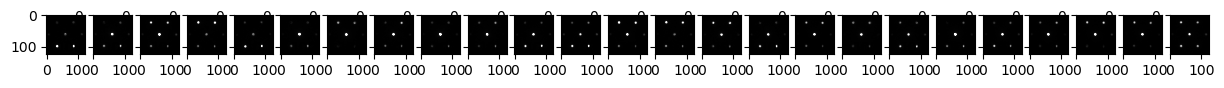

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=n_members, figsize=(15,20))
for idx, axis in enumerate(axes):
    axis.imshow(Ae[:,idx].reshape(ky,kx), vmin=0, vmax=intensity_range)
    # axis.scatter([kx/2],[ky/2])

## pseudo-inverse, least squares regression to solve abundance matrix

In [26]:
S = np.matmul(spectral.T, np.matmul(np.matmul(Ae.T, masks.T).T, np.linalg.inv(np.matmul(np.matmul(Ae.T, masks.T),np.matmul(Ae.T, masks.T).T))), dtype=np.float32)

## check abundance

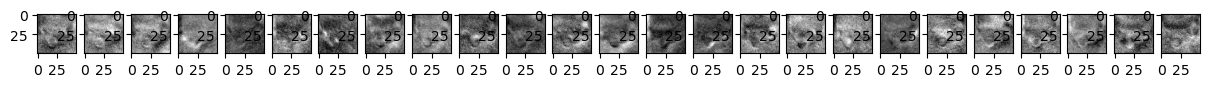

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=n_members, figsize=(15,20))
for idx, axis in enumerate(axes):
    axis.imshow(S[:,idx].reshape(ry,rx))

In [28]:
HSI = np.matmul(S, Ae.T, dtype=np.float32)

## check initial guess

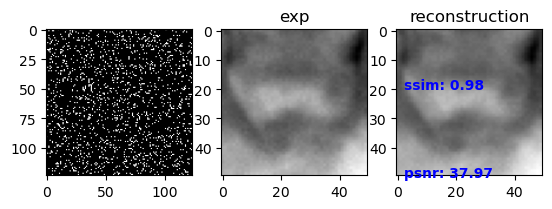

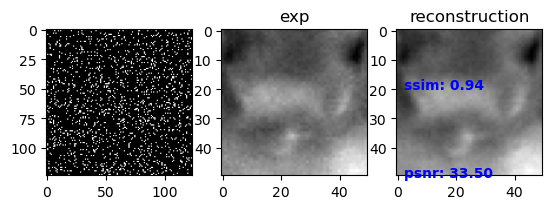

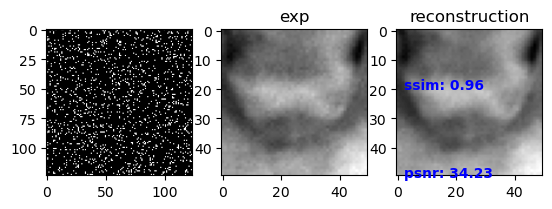

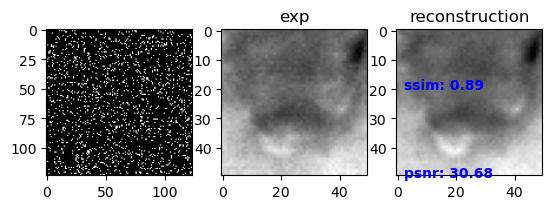

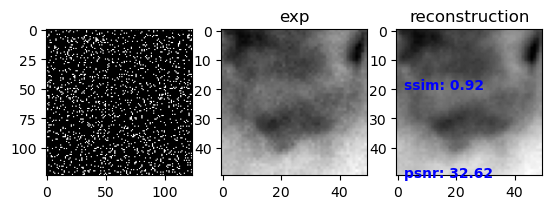

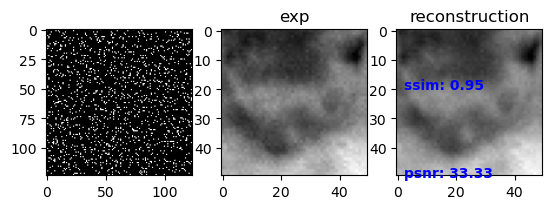

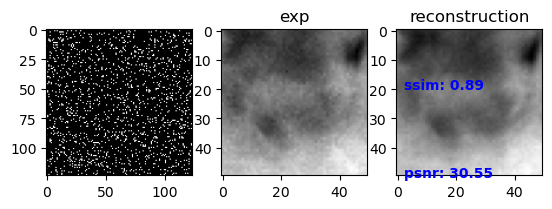

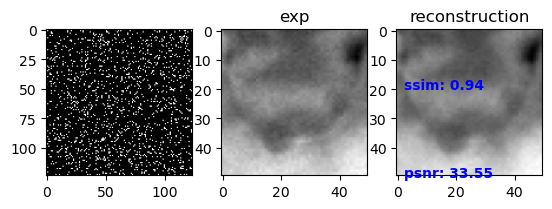

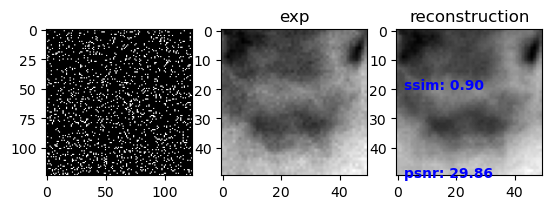

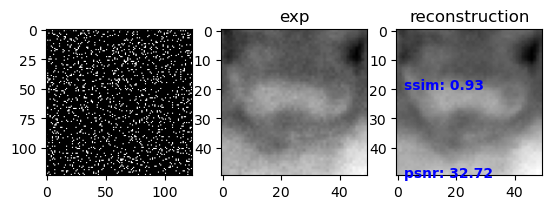

In [29]:
for mask in masks[:10]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    img = np.sum(HSI.reshape(ry,rx,ky,kx)*mask.reshape(ky,kx), axis=(2,3))
    img2 = np.sum(data.reshape(ry,rx,ky,kx)*mask.reshape(ky,kx), axis=(2,3))
    ax3.imshow(img)
    ax3.set_title("reconstruction")
    ax2.set_title("exp")
    ax2.imshow(img2)
    ax1.imshow(mask.reshape(ky,kx))
    exp_min, exp_max = ax2.get_images()[0].get_clim()
    rec_min, rec_max = ax3.get_images()[0].get_clim()
    dr = max(exp_max, rec_max) - min(exp_min, rec_min) 
    ax3.text(2, 20, f'ssim: {ssim(img, img2, data_range=dr):.2f}', color='b', weight='bold')
    ax3.text(2, 50, f'psnr: {psnr(img, img2, data_range=dr):.2f}', color='b', weight='bold')

## joint optimzation (alternative direction method)

In [33]:
lambda1 = 1
lambda2 = 1
S_k = S.copy()
A_k = Ae.copy().astype(np.float32)
HSI_k = HSI.copy()
data2d = data.reshape(rx*ry, kx*ky)

In [34]:
rel_changes = []
losses = []

avgssim = []
avgpsnr = []

for nIterations in range(200):
    C = np.vstack((HSI_k, np.sqrt(lambda1)*spatial))
    D = np.vstack((S_k, np.sqrt(lambda1)*np.matmul(mask_spa, S_k)))
    A_k, res, _, _ = np.linalg.lstsq(D,C, rcond=None)
    

    H = np.vstack((HSI_k.T, np.sqrt(lambda2)*spectral))
    Q = np.vstack((A_k.T, np.sqrt(lambda2)*np.matmul(masks, A_k.T)))
    S_k, res, _, _ = np.linalg.lstsq(Q, H, rcond=None)
    
    S_k = S_k.T

    #4D stem dataset reconstruction 
    new_HSI = np.matmul(S_k,A_k)


    rel_change = np.sum((HSI_k - new_HSI)**2)/np.sum(new_HSI**2)
    
    ssims = []
    psnrs = []
    for i in range(rx*ry):
        ssims.append(ssim(new_HSI[i,:], data2d[i,:], data_range=intensity_range))
        psnrs.append(psnr(new_HSI[i,:], data2d[i,:], data_range=intensity_range))
    loss = np.mean((new_HSI-data.reshape(rx*ry, kx*ky))**2)
    if nIterations % 10 == 0:
        
        print(f"iteration: {nIterations}")
        print(f"relative change: {rel_change}")
        print(f"mse loss: {loss}")
        print(f"avg ssim: {np.mean(ssims)}")
        print(f"avg psnr: {np.mean(psnrs)}")

    
    rel_changes.append(rel_change)
    losses.append(loss)
    avgssim.append(np.mean(ssims))
    avgpsnr.append(np.mean(psnrs))

    if rel_change < 1e-7:
        break
    HSI_k = new_HSI
    

iteration: 0
relative change: 5.4656223486227556e-06
mse loss: 332122.43730088975
avg ssim: 0.9493036227778741
avg psnr: 39.0268843826161
iteration: 10
relative change: 9.059350784069991e-07
mse loss: 324940.06613521633
avg ssim: 0.9501279065866649
avg psnr: 39.122343418103725
iteration: 20
relative change: 4.112089074230173e-07
mse loss: 321825.93835978303
avg ssim: 0.950507604460265
avg psnr: 39.161574998818736
iteration: 30
relative change: 2.134392246373984e-07
mse loss: 320323.67208921124
avg ssim: 0.9507012988082152
avg psnr: 39.178935755012326
iteration: 40
relative change: 1.2308294631687202e-07
mse loss: 319533.0177059436
avg ssim: 0.9508089802737921
avg psnr: 39.1870582982306


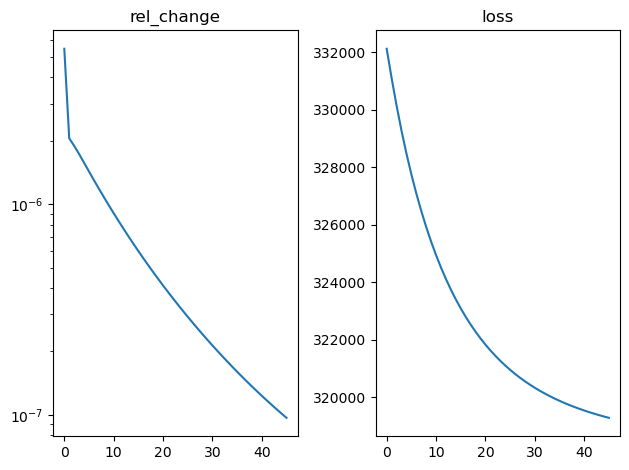

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(rel_changes)


ax1.set_title("rel_change")
ax1.set_yscale('log')
ax2.plot(losses)
ax2.set_title("loss")

plt.tight_layout()

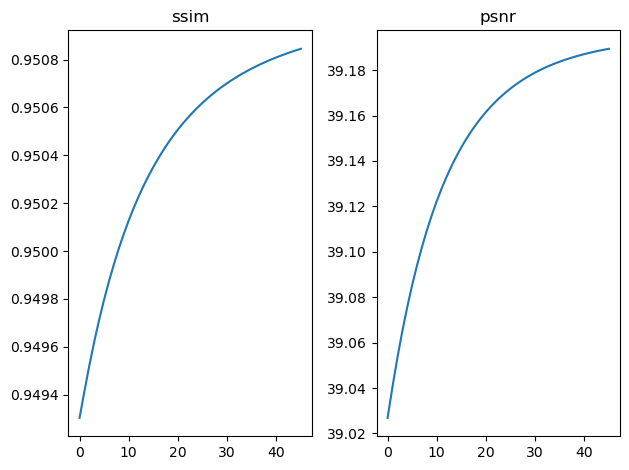

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(avgssim)
# ax12 = ax1.twinx()
# ax12.plot(rel_changes)
# ax12.set_yscale('log')
ax1.set_title("ssim")

ax2.plot(avgpsnr)
# ax22 = ax2.twinx()
# ax22.plot(rel_changes)
ax2.set_title("psnr")



plt.tight_layout()

## save optimization process record

In [35]:
avgpsnr = np.array(avgpsnr)
avgssim = np.array(avgssim)
rel_changes = np.array(rel_changes)
losses = np.array(losses)

np.save(r"avgpsnr.npy", avgpsnr, )
np.save(r"avgssim.npy", avgssim, )
np.save(r"rel_chg.npy", rel_changes)
np.save(r"loss.npy", losses)


## check some virtual images

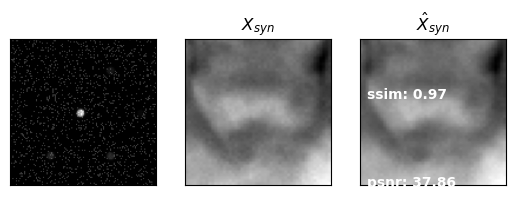

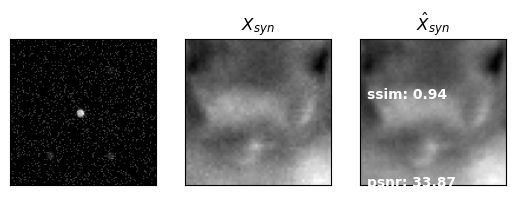

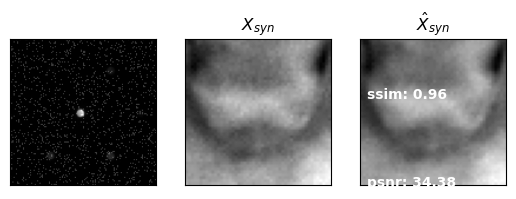

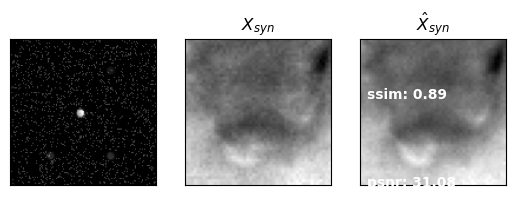

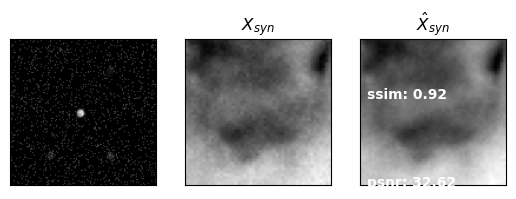

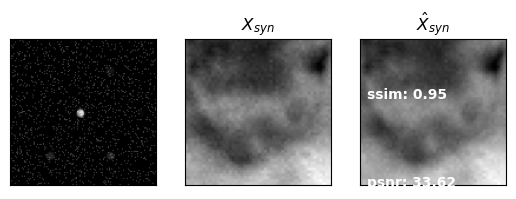

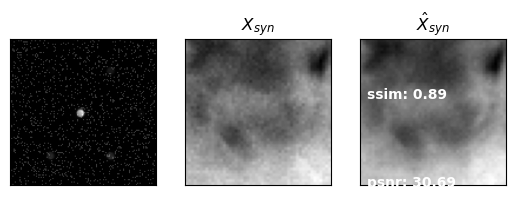

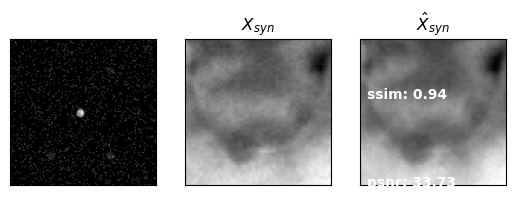

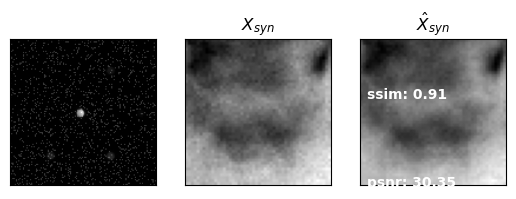

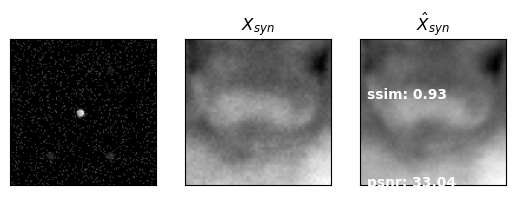

In [38]:
for mask in masks[:10]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    img = np.sum(new_HSI.reshape(ry,rx,ky,kx)*mask.reshape(ky,kx), axis=(2,3))
    img2 = np.sum(data.reshape(ry,rx,ky,kx)*mask.reshape(ky,kx), axis=(2,3))
    ax1.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax3.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax3.imshow(img)
    ax3.set_title(r"$\hat{X}_{syn}$")
    ax2.set_title(r"$X_{syn}$")
    ax2.imshow(img2)
    ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax1.imshow(mask.reshape(ky,kx)+example)
    exp_min, exp_max = ax2.get_images()[0].get_clim()
    rec_min, rec_max = ax3.get_images()[0].get_clim()
    dr = max(exp_max, rec_max) - min(exp_min, rec_min) 
    ax3.text(2, 20, f'ssim: {ssim(img, img2, data_range=dr):.2f}', color='white', weight='bold')
    ax3.text(2, 50, f'psnr: {psnr(img, img2, data_range=dr):.2f}', color='white', weight='bold')

In [31]:
intensity_range = 50000

## compare diffraction patterns

Text(0.5, 1.0, 'exp')

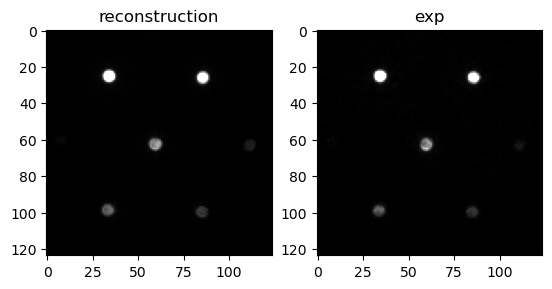

In [40]:
index = 1000
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(HSI_k[index,:].reshape(ky,kx), vmax=intensity_range, vmin=0)
ax1.set_title("reconstruction")
ax2.imshow(data.reshape(rx*ry, kx*ky)[index,:].reshape(ky,kx), vmax=intensity_range, vmin=0)
ax2.set_title("exp")

## SSIM and PSNR maps

In [41]:
ssims = []
psnrs = []
for i in range(rx*ry):
    print(i, end='\r')
    ssims.append(ssim(new_HSI[i,:], data2d[i,:], data_range=intensity_range))
    psnrs.append(psnr(new_HSI[i,:], data2d[i,:], data_range=intensity_range))

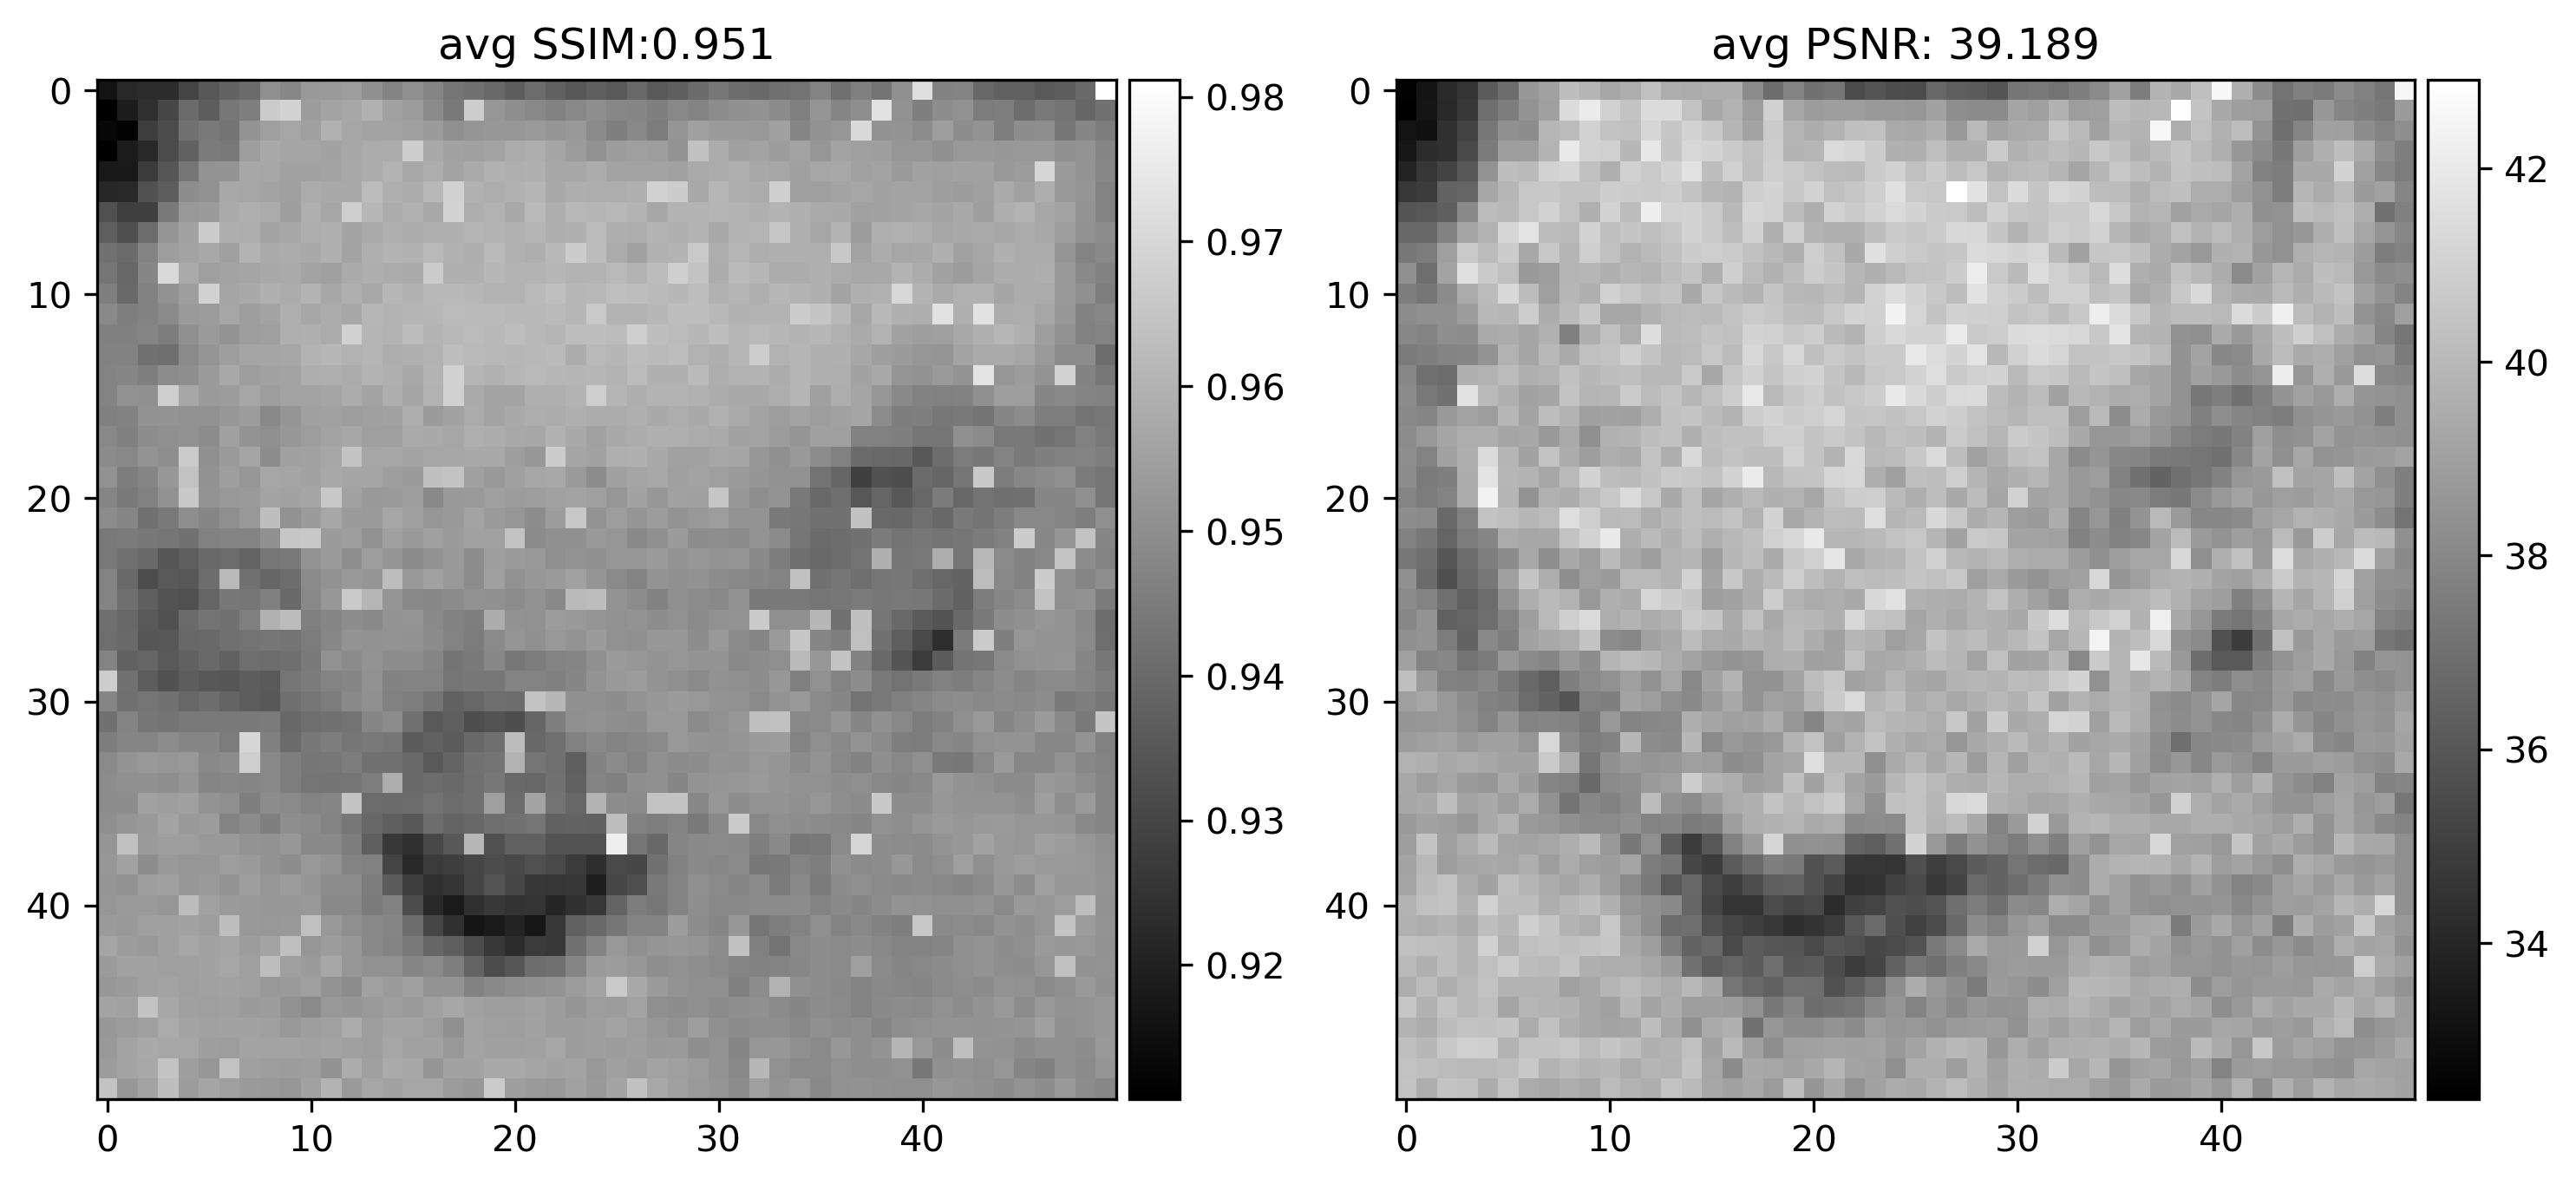

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, (ax1,ax2) = plt.subplots(1, 2, dpi=300, figsize=(10,5))
im1 = ax1.imshow(np.array(ssims).reshape(ry,rx))
ax1.set_title(f"avg SSIM:{np.mean(ssims):.3f}")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax)
im2 = ax2.imshow(np.array(psnrs).reshape(ry,rx))
ax2.set_title(f"avg PSNR: {np.mean(psnrs):.3f}")
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax)
plt.tight_layout()

## compare bright-field images

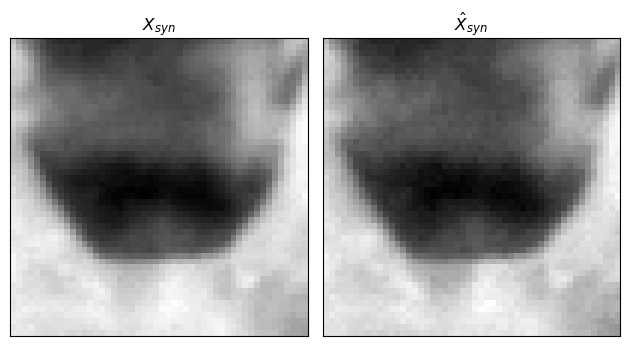

In [43]:
X,Y = np.meshgrid((np.arange(0,ky)-ky/2),(np.arange(0,kx)-kx/2), indexing='xy')
bf = ((X**2+Y**2>40**2))
data_bf = np.sum(data*bf, axis=(2,3))
HSI_bf = np.sum(new_HSI.reshape(ry,rx,ky,kx)*bf, axis=(2,3))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
im1 = ax1.imshow(data_bf)
ax1.set_title(r"$X_{syn}$")
ax1.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax2.set_title(r"$\hat{X}_{syn}$")
im2 = ax2.imshow(HSI_bf)
ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax)
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax)
plt.tight_layout()


## visualize endmember and abundance matrices

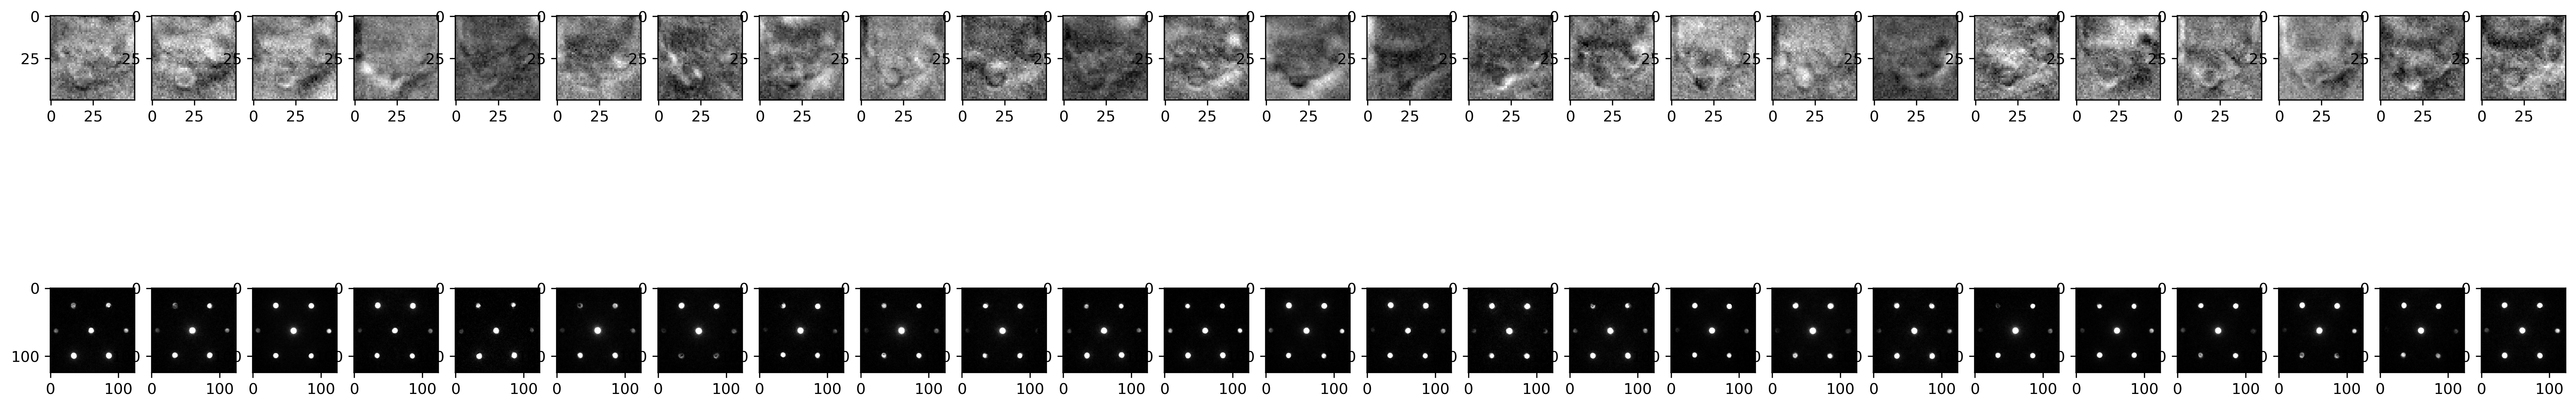

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=n_members, figsize=(30,6), dpi=300)
for i in range(S_k.shape[1]):
    im = axes[0,i].imshow(S_k[:,i].reshape((ry,rx)))
    # divider = make_axes_locatable(axes[0,i])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(im, cax=cax)
    # axes[0,i].scatter([8,11,9,12,21,24,22,25],[27,23,15,12,24,20,12,8],color='yellow')
    axes[1,i].imshow(A_k[i,:].reshape(ky,kx), vmin=0, vmax=10000)


## save reconstruction

In [42]:
from os.path import join
path = r'save/your/reconstruction/somewhere'
np.save(join(path,'ssims.npy'),ssims)
np.save(join(path,'psnrs.npy'),psnrs)
np.save(join(path,'reconstructed_HSI.npy'),new_HSI)
np.save(join(path,'endmembers.npy'), A_k.reshape(ky,kx,-1))
np.save(join(path,'abundance.npy'), S_k.reshape(ry,rx,-1))
# np.save(join(path,'relative_change.npy'),np.array(rel_change))
# np.save(join(path,'loss.npy'),np.array(losses))
# np.save(join(path,'spatial sample.npy'), spatial_sample)
np.save(join(path,'masks.npy'), masks)

In [43]:
import struct
header = struct.pack('HHHH', kx, ky, 4, 2)
with open(join(path,'reconstructed_HSI.img'), 'wb') as f:
    f.write(header + new_HSI.astype(np.float32).tobytes())
with open(join(path,'endmembers.img'), 'wb') as f:
    f.write(header + A_k.reshape(-1,ky,kx).astype(np.float32).tobytes())
header = struct.pack('HHHH', rx, ry, 4, 2)
with open(join(path,'abundance.img'), 'wb') as f:
    f.write(header + S_k.T.reshape(-1,ry,rx).astype(np.float32).tobytes())

In [45]:
with open(join(path,"reconstruction parameters.txt"), "w") as f:
    f.write(f"kx {kx}\n")
    f.write(f"ky {ky}\n")
    f.write(f"rx {rx}\n")
    f.write(f"ry {ry}\n")
    f.write(f"n masks {n_spec}\n")
    # f.write(f"BF mask {BFoutside}, DF mask {DFinside}::{DFoutside}")
    f.write(f"nPoints {n_spa}\n")
    f.write(f"n member {n_members}\n")
    f.write(f"lambda1 {lambda1}\n")
    f.write(f"lambda2 {lambda2}\n")
    # f.write(f"iterations {nIterations}\n") #nIterations
    f.write("note: ")
    